(120, 128)


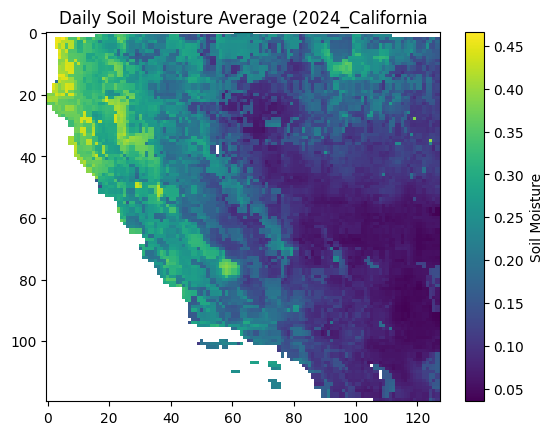

In [53]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

dataset = rasterio.open('Daily_SM_Surface_2024_2024_California.tif')

soil_moisture_data = dataset.read(1)

print(soil_moisture_data.shape)

plt.imshow(soil_moisture_data, cmap='viridis')
plt.colorbar(label='Soil Moisture')
plt.title('Daily Soil Moisture Average (2024_California')
plt.show()


In [54]:
dataset = rasterio.open('Daily_SM_Surface_2024_2024_California.tif')

soil_moisture_data = dataset.read()
print("Dimensions (Days, Height, Width):", soil_moisture_data.shape)

print("Number of NaN values:", np.isnan(soil_moisture_data).sum())

soil_moisture_data = np.where(soil_moisture_data < 0, 0, soil_moisture_data)

Dimensions (Days, Height, Width): (2170, 120, 128)
Number of NaN values: 8378225


In [55]:
import rasterio
import numpy as np
import pandas as pd
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days) + 1):
        yield start_date + timedelta(n)

# Read GeoTIFF file
dataset = rasterio.open('Daily_SM_Surface_2024_2024_California.tif')

# Extract data from the file (days, height, width)
soil_moisture_data = dataset.read()
num_days, height, width = soil_moisture_data.shape

# Generate a grid of coordinates (latitude, longitude) for each pixel
coords = np.array([dataset.xy(row, col) for row in range(height) for col in range(width)])
lons, lats = coords[:, 0], coords[:, 1]

# Generate a list of daily dates from 2020 to 2021
start_date = date(2020, 1)
end_date = date(2024,9 )
dates = list(daterange(start_date, end_date))

# Reshape soil moisture data to (days, pixels) for easier processing
soil_moisture_reshaped = soil_moisture_data.reshape(num_days, -1)

# Find the pixels (lat, lon) that have all NaN values across the year
nan_mask = np.isnan(soil_moisture_reshaped).all(axis=0)

# Filter out coordinates where all values are NaN
valid_lats = lats[~nan_mask]
valid_lons = lons[~nan_mask]
valid_soil_moisture = soil_moisture_reshaped[:, ~nan_mask]

# Allow a few NaNs, but remove points that have excessive NaN values
max_nan_threshold = int(0.1 * num_days)  # Allow up to 10% NaN values
valid_mask = np.isnan(valid_soil_moisture).sum(axis=0) <= max_nan_threshold

final_lats = valid_lats[valid_mask]
final_lons = valid_lons[valid_mask]
final_soil_moisture = valid_soil_moisture[:, valid_mask]

# Create DataFrame for each day and concatenate into a final DataFrame
data_frames = []
for i, single_date in enumerate(dates):
    sm_values = final_soil_moisture[i, :]
    
    df = pd.DataFrame({
        'Date': single_date,
        'Latitude': final_lats,
        'Longitude': final_lons,
        'Soil_Moisture': sm_values
    })
    
    data_frames.append(df)

# Combine all DataFrames into one
soil_moisture_df = pd.concat(data_frames, ignore_index=True)

# Save the data as a CSV file
soil_moisture_df.to_csv('Daily_SM_Surface_2024_2024_California.csv', index=False)

print("Filtered CSV file saved successfully!")


Filtered CSV file saved successfully!


In [56]:
df = pd.read_csv("Daily_SM_Surface_2024_2024_California.csv")
df

,Date,Latitude,Longitude,Soil_Moisture
0,2024-01-01,42.154681,-119.484649,0.248617
1,2024-01-01,42.154681,-119.403800,0.209178
2,2024-01-01,42.154681,-119.322951,0.241802
3,2024-01-01,42.154681,-119.242102,0.245122
4,2024-01-01,42.154681,-119.161253,0.240048
...,...,...,...,...
3166620,2024-10-01,32.533779,-114.472021,0.097031
3166621,2024-10-01,32.533779,-114.391172,0.160031
3166622,2024-10-01,32.533779,-114.310323,0.125719
3166623,2024-10-01,32.533779,-114.229475,0.111660


In [57]:
df.describe()

,Latitude,Longitude,Soil_Moisture
count,3.166625e+06,3.166625e+06,3.166616e+06
mean,3.804481e+01,-1.183499e+02,2.016894e-01
std,2.559647e+00,2.662468e+00,1.012415e-01
min,3.253378e+01,-1.244164e+02,3.104494e-02
25%,3.601024e+01,-1.204548e+02,1.171003e-01
50%,3.827398e+01,-1.181102e+02,1.841107e-01
75%,4.021433e+01,-1.160890e+02,2.732846e-01
max,4.215468e+01,-1.141486e+02,8.589033e-01


In [58]:
df.isnull().sum()

Date             0
Latitude         0
Longitude        0
Soil_Moisture    9
dtype: int64

In [59]:
# Group by Latitude and Longitude to count unique regions and occurrences
lat_long_counts = df.groupby(['Latitude', 'Longitude']).size().reset_index(name='Counts')

# Number of unique regions (lat, long pairs)
num_unique_regions = lat_long_counts.shape[0]

# Print the total number of unique regions
print(f"Number of unique (Latitude, Longitude) pairs (regions): {num_unique_regions}")

# Print the count of occurrences for each region (lat, long pair)
print(lat_long_counts)

# Save the counts of lat/long occurrences as CSV if needed
lat_long_counts.to_csv('Lat_Lon_Region_Counts_2024_2024.csv', index=False)

print("Lat/Lon counts CSV file saved successfully!")


Number of unique (Latitude, Longitude) pairs (regions): 11515
        Latitude   Longitude  Counts
0      32.533779 -115.846451     275
1      32.533779 -115.765602     275
2      32.533779 -115.684753     275
3      32.533779 -115.603905     275
4      32.533779 -115.523056     275
...          ...         ...     ...
11510  42.154681 -119.403800     275
11511  42.154681 -119.322951     275
11512  42.154681 -119.242102     275
11513  42.154681 -119.161253     275
11514  42.154681 -119.080404     275

[11515 rows x 3 columns]
Lat/Lon counts CSV file saved successfully!


In [60]:
pd.read_csv('Lat_Lon_Region_Counts_2024_2024.csv')

,Latitude,Longitude,Counts
0,32.533779,-115.846451,275
1,32.533779,-115.765602,275
2,32.533779,-115.684753,275
3,32.533779,-115.603905,275
4,32.533779,-115.523056,275
...,...,...,...
11510,42.154681,-119.403800,275
11511,42.154681,-119.322951,275
11512,42.154681,-119.242102,275
11513,42.154681,-119.161253,275


In [1]:
import pandas as pd

# List of file names
files = [
    'Daily_SM_Surface_2020_2021_California.csv',
    'Daily_SM_Surface_2021_2022_California.csv',
    'Daily_SM_Surface_2022_2023_California.csv',
    'Daily_SM_Surface_2023_2024_California.csv',
    'Daily_SM_Surface_2024_2024_California.csv'
]

# Initialize an empty DataFrame to store all valid data
df_combined = pd.DataFrame()

# Loop through each file
for file in files:
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Attempt to standardize the Date format
    # Convert from YYYY-MM-DD to DD/MM/YYYY if needed
    if df['Date'].str.match(r'^\d{4}-\d{2}-\d{2}$').any():
        df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.strftime('%d/%m/%Y')  # Convert to DD/MM/YYYY
    else:
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')  # Convert to DD/MM/YYYY
    
    # Collect only rows where Date is not NaT after formatting
    df = df[df['Date'].notna()]
    
    # Concatenate the DataFrame
    df_combined = pd.concat([df_combined, df], ignore_index=True)

# Save the combined DataFrame to a new CSV
df_combined.to_csv('Combined_Soil_Moisture_Data_California.csv', index=False)

# Print the number of rows in the combined DataFrame
print(f"Number of rows after combining: {df_combined.shape[0]}")


Number of rows after combining: 20079222


In [3]:
# Group by Latitude and Longitude to count unique regions and occurrences
lat_long_counts = df_combined.groupby(['Latitude', 'Longitude']).size().reset_index(name='Counts')

num_unique_regions = lat_long_counts.shape[0]

print(f"Number of unique (Latitude, Longitude) pairs (regions): {num_unique_regions}")

print(lat_long_counts)



Number of unique (Latitude, Longitude) pairs (regions): 23028
        Latitude   Longitude  Counts
0      32.533482 -115.846814    1469
1      32.533482 -115.765966    1469
2      32.533482 -115.685117    1469
3      32.533482 -115.604269    1469
4      32.533482 -115.523420    1469
...          ...         ...     ...
23023  42.154681 -119.403800     275
23024  42.154681 -119.322951     275
23025  42.154681 -119.242102     275
23026  42.154681 -119.161253     275
23027  42.154681 -119.080404     275

[23028 rows x 3 columns]


In [6]:
data = pd.read_csv('Combined_Soil_Moisture_Data_California.csv', parse_dates=['Date'], dayfirst=True)

region_counts = data.groupby(['Latitude', 'Longitude']).size().reset_index(name='count')

# Find the region with the maximum number of observations (reference region)
max_observations = region_counts['count'].max()
reference_region = region_counts[region_counts['count'] == max_observations]

# Find regions with fewer observations
regions_with_missing_obs = region_counts[region_counts['count'] < max_observations]

# Identify the missing date periods for regions with fewer observations
for index, row in regions_with_missing_obs.iterrows():
    region_data = data[(data['Latitude'] == row['Latitude']) & (data['Longitude'] == row['Longitude'])]
    all_dates = pd.date_range(start=data['Date'].min(), end=data['Date'].max())
    region_dates = pd.to_datetime(region_data['Date'])
    missing_dates = all_dates.difference(region_dates)
    
    print(f"Region: ({row['Latitude']}, {row['Longitude']})")
    print(f"Missing dates: {missing_dates}")


Region: (32.53377892440937, -115.84645116179324)
Missing dates: DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', length=1461, freq='D')
Region: (32.53377892440937, -115.76560232897889)
Missing dates: DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64

KeyboardInterrupt: 

In [14]:
df_combined

,Date,Latitude,Longitude,Soil_Moisture
0,01/01/2020,42.154439,-119.484991,0.242120
1,01/01/2020,42.154439,-119.404142,0.208612
2,01/01/2020,42.154439,-119.323294,0.225763
3,01/01/2020,42.154439,-119.242446,0.233575
4,01/01/2020,42.154439,-119.161597,0.234979
...,...,...,...,...
20079217,01/10/2024,32.533779,-114.472021,0.097031
20079218,01/10/2024,32.533779,-114.391172,0.160031
20079219,01/10/2024,32.533779,-114.310323,0.125719
20079220,01/10/2024,32.533779,-114.229475,0.111660


In [15]:
df_combined.isnull().sum()

Date             0
Latitude         0
Longitude        0
Soil_Moisture    9
dtype: int64

In [10]:
import pandas as pd

# List of file names
files = [
    'Daily_SM_Surface_2020_2021_California.csv',
    'Daily_SM_Surface_2021_2022_California.csv',
    'Daily_SM_Surface_2022_2023_California.csv',
    'Daily_SM_Surface_2023_2024_California.csv',
    'Daily_SM_Surface_2024_2024_California.csv'
]

# Initialize an empty DataFrame to store invalid dates
invalid_dates_combined = pd.DataFrame()

# Loop through each file
for file in files:
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Attempt to parse the Date column
    df['Parsed_Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    
    # Collect rows where parsing failed (resulting in NaT)
    invalid_dates = df[df['Parsed_Date'].isna()]
    
    # If there are any invalid dates, add them to the combined DataFrame
    if not invalid_dates.empty:
        invalid_dates_combined = pd.concat([invalid_dates_combined, invalid_dates], ignore_index=True)

# Save the rows with invalid dates to a new CSV for inspection
invalid_dates_combined.to_csv('Invalid_Dates.csv', index=False)

# Print the number of invalid dates found
print(f"Number of rows with invalid dates across all files: {len(invalid_dates_combined)}")


Number of rows with invalid dates across all files: 12100495


In [12]:
ff = pd.read_csv("Invalid_Dates.csv")
ff['Date'][0:10]

0    2020-01-13
1    2020-01-13
2    2020-01-13
3    2020-01-13
4    2020-01-13
5    2020-01-13
6    2020-01-13
7    2020-01-13
8    2020-01-13
9    2020-01-13
Name: Date, dtype: object